Getting the stats in the raw data to see how the features are distributted.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from IPython.display import display, HTML

plt.style.use('ggplot')

sqluser = 'postgres'
dbname = 'mimic_demo'
schema_name = 'mimiciii_generate'
password = '012500'
con = psycopg2.connect(dbname=dbname, user=sqluser, password=password)
query_schema = 'set search_path to ' + schema_name + ';'

当前统计是在未筛选情况下。考虑分布情况后，做筛选，在做一次统计

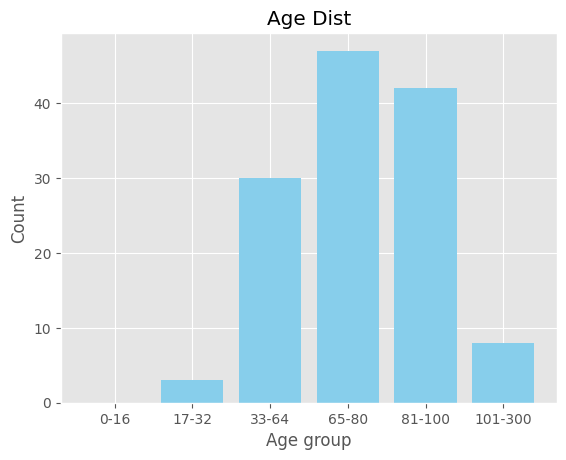

In [9]:
age_query = '''
select distinct subject_id, age_inicu_year 
from mimiciii_generate.patient_complete
where subject_id is not null
order by subject_id
'''
patient_complete = pd.read_sql_query(age_query, con)
bins = [0, 16, 32, 64, 80, 100,300]
labels = ['0-16', '17-32', '33-64', '65-80', '81-100', '101-300']
patient_complete.head(10)
#age_counts = patient_cpmplete['age_inicu_year'].value_counts().sort_index()
#print(age_counts)

patient_complete['age_group'] = pd.cut(patient_complete['age_inicu_year'], bins=bins, labels=labels, right=False)

age_distribution = patient_complete['age_group'].value_counts().sort_index()
age_distribution = age_distribution.reset_index()
age_distribution.columns = ['Age Group', 'Count']


plt.bar(age_distribution['Age Group'], age_distribution['Count'], color='skyblue')
plt.title('Age Dist')
plt.xlabel('Age group')
plt.ylabel('Count')
plt.show()
#rint(age_distribution)


  index  gender
0     F      54
1     M      43


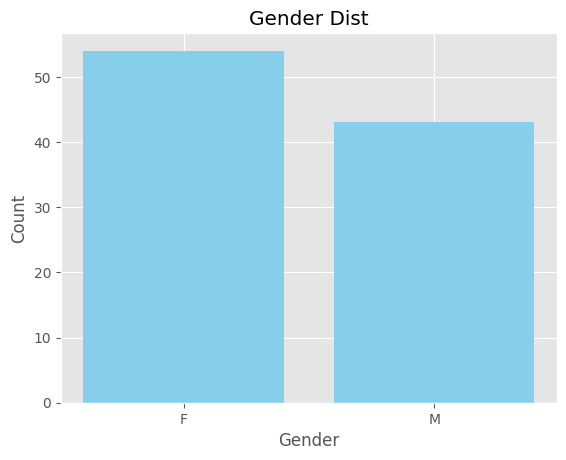

In [10]:
gender_query = '''
select distinct subject_id, gender 
from mimiciii_generate.patient_complete
where subject_id is not null
order by subject_id
'''
patient_gender = pd.read_sql_query(gender_query, con)
gender_count = patient_gender['gender'].value_counts().reset_index()
print(gender_count)
gender_count.columns = ['gender','count']

plt.bar(gender_count['gender'], gender_count['count'],color='skyblue')
plt.title('Gender Dist')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

统计各个病症的数量。

存入数据库！

In [11]:
diag_only_query = '''
select distinct diagnosis, count(distinct icustay_id) as num
from mimiciii_generate.patient_complete
where subject_id is not null 
group by diagnosis
order by diagnosis asc;
'''
diagnosis_num = pd.read_sql_query(diag_only_query, con)

diagnosis_num.head(10)



,diagnosis,num
0,MITRAL REGURGITATION;CORONARY ARTERY DISEASE\...,1
1,ABDOMINAL PAIN,1
2,ABSCESS,1
3,ACUTE CHOLANGITIS,2
4,ACUTE CHOLECYSTITIS,1
5,ACUTE PULMONARY EMBOLISM,1
6,ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...,1
7,ACUTE SUBDURAL HEMATOMA,1
8,ALCOHOLIC HEPATITIS,1
9,ALTERED MENTAL STATUS,1


假设针对sepsis统计。图很丑，先不管

                        index  diagnosis
0                      SEPSIS          8
1                 SEPSIS; UTI          1
2  SEPSIS;PNEUMONIA;TELEMETRY          1
3            SEPSIS;TELEMETRY          1
4                   UROSEPSIS          1


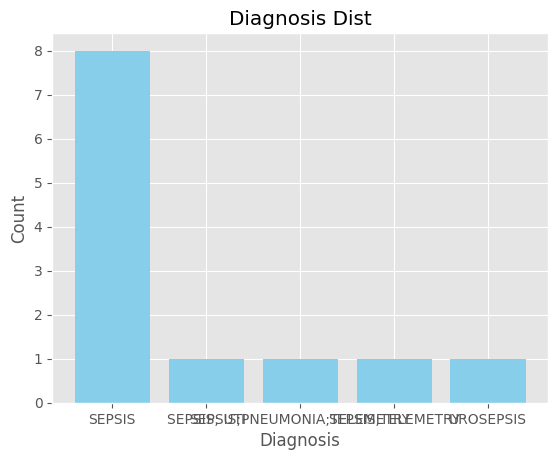

In [12]:

diag_query = '''
select distinct icustay_id, diagnosis 
from mimiciii_generate.patient_complete
where subject_id is not null
and diagnosis ~* 'sepsis' 
order by icustay_id
'''
patient_diagnosis = pd.read_sql_query(diag_query, con)
diag_count = patient_diagnosis['diagnosis'].value_counts().reset_index()
print(diag_count)
diag_count.columns = ['diag','count']

plt.bar(diag_count['diag'], diag_count['count'],color='skyblue')
plt.title('Diagnosis Dist')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()
#

In [20]:
patient_sepsis_complete_query = '''
WITH   patient_sepsis as (
        select * from mimiciii_generate.patient_complete
        where diagnosis ~*'sepsis'
        )
        select * from patient_sepsis
    
'''

patient_sepsis_complete = pd.read_sql_query(patient_sepsis_complete_query, con)
case_num = patient_sepsis_complete['icustay_id'].nunique()
test_counts = patient_sepsis_complete.groupby('test_label')['icustay_id'].nunique()
test_percent = (test_counts / case_num * 100).round(2).reset_index()
test_percent.columns = ['test_label', 'test_percent']
test_percent = test_percent.sort_values(by='test_percent', ascending=False).reset_index(drop=True)
print(test_percent)

                 test_label  test_percent
0                calprevflg         58.33
1              Heart Rhythm         58.33
2       Potassium (3.5-5.3)         58.33
3                       HOB         58.33
4          Glucose (70-105)         58.33
..                      ...           ...
357    GI#1 Tube PlaceCheck          8.33
358   Pupil Response [Left]          8.33
359  Pupil Response [Right]          8.33
360       Pupil Size [Left]          8.33
361    RU Strength/Movement          8.33

[362 rows x 2 columns]


Focus on patients that are:

100 > age > 16

icu_times_total = icu_times 
即，只考虑最后一次进ICU的情况。若有多次进入ICU，那么同一人的多次入院的检测数据会有multilinear
仅针对某种病症（e.g. sepsis）

In [14]:
filter_query = '''
    with patient_complete_filter as (
        select *
        from patient_conplete
        where 
    )
'''